#Task 1: Comparing the performance of fine tuning and training from scratch
Machine Learning Assignment

Duy Tran

19313551

17.05.2022

In [ ]:
!pip install -U d2l

In [2]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from d2l import torch as d2l

In [3]:
# prepare dataset
# ref: https://pytorch.org/vision/stable/models.html
transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

#validation and training set
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#download 10000 testing dataset (train=False)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

num_classes = 10

# split 50k dataset into train and validation
# ref: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
train_size = int(0.7 * len(full_dataset))
validation_size = len(full_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, 
                                    [train_size, validation_size])

Files already downloaded and verified
Files already downloaded and verified


In [4]:

#load test dataset
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=128, 
                                    shuffle=True, num_workers = 4)

In [5]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
# ref: d2l.ai -> https://d2l.ai/chapter_computer-vision/fine-tuning.html?highlight=train_fine_tune
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
                      
    devices = d2l.try_all_gpus()

    #load training dataset
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=4)
    #load validation dataset
    validation_iter = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=4)
    
    loss = nn.CrossEntropyLoss()
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, validation_iter, loss, trainer, num_epochs,
                   devices)


### Finetune test

loss 0.004, train acc 0.832, test acc 0.724
5262.2 examples/sec on [device(type='cuda', index=0)]


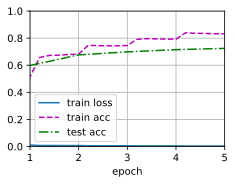

In [6]:
net = torchvision.models.resnet18(pretrained=True)
#reshape output layer to #num classes 
net.fc = nn.Linear(net.fc.in_features, num_classes)
nn.init.xavier_uniform_(net.fc.weight);
train_fine_tuning(net, 5e-3)

In [7]:
#check accuracy with test data
d2l.evaluate_accuracy_gpu(net, test_iter)

0.7261

Increased epoch




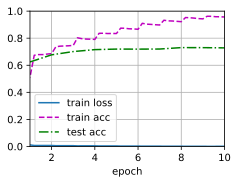

In [8]:
net = torchvision.models.resnet18(pretrained=True)
#reshape output layer to #num classes 
net.fc = nn.Linear(net.fc.in_features, num_classes)
nn.init.xavier_uniform_(net.fc.weight);
train_fine_tuning(net, 5e-3, num_epochs=10)

In [9]:
#check accuracy with test data
d2l.evaluate_accuracy_gpu(net, test_iter)

0.722

### Scratch test

pretrained=False

loss 0.008, train acc 0.664, test acc 0.521
5221.9 examples/sec on [device(type='cuda', index=0)]


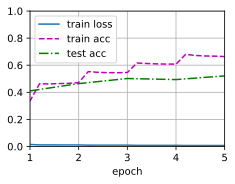

In [10]:
net = torchvision.models.resnet18(pretrained=False)
#reshape output layer to #num classes 
net.fc = nn.Linear(net.fc.in_features, num_classes)
nn.init.xavier_uniform_(net.fc.weight);
train_fine_tuning(net, 5e-3, param_group=False)

In [11]:
#check accuracy with test data
d2l.evaluate_accuracy_gpu(net, test_iter)

0.5121